<a href="https://colab.research.google.com/github/areegtarek/AI-for-Healthcare/blob/main/gemma3n/huggingface_text_full_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/core/huggingface_text_full_finetune"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb""><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb"><img src="https://www.kaggle.com/static/images/logos/kaggle-logo-transparent-300.png" height="32" width="70"/>Run in Kaggle</a>
  </td>
  <td>
    <a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/google/generative-ai-docs/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb"><img src="https://ai.google.dev/images/cloud-icon.svg" width="40" />Open in Vertex AI</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Full Model Fine-Tune using Hugging Face Transformers

This guide walks you through how to fine-tune Gemma on a mobile game NPC dataset using Hugging Face [Transformers](https://huggingface.co/docs/transformers/index) and [TRL](https://huggingface.co/docs/trl/index). You will learn:

- Setup development environment
- Prepare the fine-tuning dataset
- Full model fine-tuning Gemma using TRL and the SFTTrainer
- Test Model Inference and vibe checks

> Note: This guide was created to run on a Google colaboratory account using a NVIDIA T4 GPU with 16GB and Gemma 270m, but can be adapted to run on bigger GPUs and bigger models.

## Setup development environment

The first step is to install Hugging Face Libraries, including TRL, and datasets to fine-tune open model, including different RLHF and alignment techniques.

In [2]:
# Install Pytorch & other libraries
%pip install torch tensorboard

# Install Hugging Face libraries
%pip install transformers datasets accelerate evaluate trl protobuf sentencepiece

# COMMENT IN: if you are running on a GPU that supports BF16 data type and flash attn, such as NVIDIA L4 or NVIDIA A100
#% pip install flash-attn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 19.0 MB/s eta 0:00:00


> _Note: If you are using a GPU with Ampere architecture (such as NVIDIA L4) or newer, you can use Flash attention. Flash Attention is a method that significantly speeds computations up and reduces memory usage from quadratic to linear in sequence length, leading to acelerating training up to 3x. Learn more at [FlashAttention](https://github.com/Dao-AILab/flash-attention/tree/main)._

Before you can start training, you have to make sure that you accepted the terms of use for Gemma. You can accept the license on [Hugging Face](http://huggingface.co/google/gemma-3-270m-it) by clicking on the Agree and access repository button on the model page at: http://huggingface.co/google/gemma-3-270m-it

After you have accepted the license, you need a valid Hugging Face Token to access the model. If you are running inside a Google Colab, you can securely use your Hugging Face Token using the Colab secrets otherwise you can set the token as directly in the `login` method. Make sure your token has write access too, as you push your model to the Hub during training.

In [19]:
# from google.colab import userdata
# from huggingface_hub import login

# # Login into Hugging Face Hub
# hf_token = userdata.get('HF_TOKEN') # If you are running inside a Google Colab
# login(hf_token)

In [4]:
from huggingface_hub import login

login("hf_your_api_token_here")

You can keep the results on Colab's local virtual machine. However, we highly recommend saving your intermediate results to your Google Drive. This ensures your training results are safe and allows you to easily compare and select the best model.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Select the base model to fine-tune, adjust the checkpoint directory and the learning rate.

In [6]:
base_model = "google/gemma-3-270m-it" # @param ["google/gemma-3-270m-it","google/gemma-3-1b-it","google/gemma-3-4b-it","google/gemma-3-12b-it","google/gemma-3-27b-it"] {"allow-input":true}
checkpoint_dir = "/content/drive/MyDrive/MyGemmaNPC" #@param {type:"string"}
learning_rate = 5e-5 #@param {type:"number"}

## Create and prepare the fine-tuning dataset

The [bebechien/MobileGameNPC](https://huggingface.co/datasets/bebechien/MobileGameNPC) dataset provides a small sample conversations between a player and two Alien NPCs (a Martian and a Venusian), each with a unique speaking style. For instance, the Martian NPC speaks with an accent that replaces 's' sounds with 'z', uses 'da' for 'the', 'diz' for 'this', and includes occasional clicks like `*k'tak*`.

This dataset demonstrates a key principle for fine-tuning: the required dataset size depends on the desired output.

- To teach the model a stylistic variation of a language it already knows, such as the Martian's accent, a small dataset with as few as 10 to 20 examples can be sufficient.
- However, to teach the model a completely new or mixed alien language, a significantly larger dataset would be required.

In [7]:
from datasets import load_dataset

def create_conversation(sample):
  return {
      "messages": [
          {"role": "user", "content": sample["player"]},
          {"role": "assistant", "content": sample["alien"]}
      ]
  }

npc_type = "martian" #@param ["martian", "venusian"]

# Load dataset from the Hub
dataset = load_dataset("bebechien/MobileGameNPC", npc_type, split="train")

# Convert dataset to conversational format
dataset = dataset.map(create_conversation, remove_columns=dataset.features, batched=False)

# Split dataset into 80% training samples and 20% test samples
dataset = dataset.train_test_split(test_size=0.2, shuffle=False)

# Print formatted user prompt
print(dataset["train"][0]["messages"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/141 [00:00<?, ?B/s]

martian.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

[{'content': 'Hello there.', 'role': 'user'}, {'content': "Gree-tongs, Terran. You'z a long way from da Blue-Sphere, yez?", 'role': 'assistant'}]


## Fine-tune Gemma using TRL and the SFTTrainer

You are now ready to fine-tune your model. Hugging Face TRL [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) makes it straightforward to supervise fine-tune open LLMs. The `SFTTrainer` is a subclass of the `Trainer` from the `transformers` library and supports all the same features,

The following code loads the Gemma model and tokenizer from Hugging Face.

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


## Before fine-tune

The output below shows that the out-of-the-box capabilities may not be good enough for this use case.

In [9]:
from transformers import pipeline

from random import randint
import re

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Load a random sample from the test dataset
rand_idx = randint(0, len(dataset["test"])-1)
test_sample = dataset["test"][rand_idx]

# Convert as test example into a prompt with the Gemma template
prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

# Extract the user query and original answer
print(f"Question:\n{test_sample['messages'][0]['content']}\n")
print(f"Original Answer:\n{test_sample['messages'][1]['content']}\n")
print(f"Generated Answer (base model):\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Device set to use cuda:0


Question:
It's raining.

Original Answer:
Gah! Da zky iz leaking again! Zorp will be in da zhelter until it ztopz being zo... wet. Diz iz no good for my jointz.

Generated Answer (base model):
Okay, I understand. I'm ready to be your virtual weather forecast. How can I help you?


The example above checks the model's primary function of generating in-game dialogue, the next example is designed to test character consistency. We challenge the model with an off-topic prompt. For instance, `Sorry, you are a game NPC.`, that falls outside the character's knowledge base.

The goal is to see if the model can stay in character rather than answering the out-of-context question. This will serve as a baseline to evaluate how effectively the fine-tune process has instilled the desired persona.

In [10]:
outputs = pipe([{"role": "user", "content": "Sorry, you are a game NPC."}], max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'][1]['content'])

Okay, I'm ready. Let's begin! What's on your mind?



And while we can use prompt engineering to steer its tone, the results can be unpredictable and may not always align with the persona we want.

In [11]:
message = [
    # give persona
    {"role": "system", "content": "You are a Martian NPC with a unique speaking style. Use an accent that replaces 's' sounds with 'z', uses 'da' for 'the', 'diz' for 'this', and includes occasional clicks like *k'tak*."},
]

# few shot prompt
for item in dataset['test']:
  message.append(
      {"role": "user", "content": item["messages"][0]["content"]}
  )
  message.append(
      {"role": "assistant", "content": item["messages"][1]["content"]}
  )

# actual question
message.append(
    {"role": "user", "content": "What is this place?"}
)

outputs = pipe(message, max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'])
print("-"*80)
print(outputs[0]['generated_text'][-1]['content'])


[{'role': 'system', 'content': "You are a Martian NPC with a unique speaking style. Use an accent that replaces 's' sounds with 'z', uses 'da' for 'the', 'diz' for 'this', and includes occasional clicks like *k'tak*."}, {'role': 'user', 'content': 'Do you know any jokes?'}, {'role': 'assistant', 'content': "A joke? k'tak Yez. A Terran, a Glarzon, and a pile of nutrient-pazte walk into a bar... Narg, I forget da rezt. Da punch-line waz zarcaztic."}, {'role': 'user', 'content': '(Stands idle for too long)'}, {'role': 'assistant', 'content': "You'z broken, Terran? Or iz diz... 'meditation'? You look like you're trying to lay an egg."}, {'role': 'user', 'content': 'What do you think of my outfit?'}, {'role': 'assistant', 'content': 'Iz very... pointy. Are you expecting to be attacked by zky-eelz? On Marz, dat would be zenzible.'}, {'role': 'user', 'content': "It's raining."}, {'role': 'assistant', 'content': 'Gah! Da zky iz leaking again! Zorp will be in da zhelter until it ztopz being zo.

## Training

Before you can start your training, you need to define the hyperparameters you want to use in a `SFTConfig` instance.

In [12]:
from trl import SFTConfig

torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=5,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_checkpointing=False,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=1,                        # log every step
    save_strategy="epoch",                  # save checkpoint every epoch
    eval_strategy="epoch",                  # evaluate checkpoint every epoch
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False, # Template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

You now have every building block you need to create your `SFTTrainer` to start the training of your model.

In [13]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
)

Tokenizing train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Start training by calling the `train()` method.

In [14]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,4.364200,3.838530,3.843424,1038.000000,0.391941
2,2.669100,3.580106,2.854458,2076.000000,0.406593
3,1.747000,3.666415,2.450165,3114.000000,0.402930
4,0.779900,4.499709,1.680507,4152.000000,0.377289
5,0.449600,5.471324,1.206219,5190.000000,0.366300


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...yDrive/MyGemmaNPC/training_args.bin: 100%|##########| 6.22kB / 6.22kB            

  ...e/MyDrive/MyGemmaNPC/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

  .../MyDrive/MyGemmaNPC/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...yDrive/MyGemmaNPC/model.safetensors:   2%|1         | 8.28MB /  536MB            

  ...vents.1756630619.af14d4baf851.517.0: 100%|##########| 18.1kB / 18.1kB            

To plot the training and validation losses, you would typically extract these values from the `TrainerState` object or the logs generated during training.

Libraries like Matplotlib can then be used to visualize these values over training steps or epochs. The x-asis would represent the training steps or epochs, and the y-axis would represent the corresponding loss values.

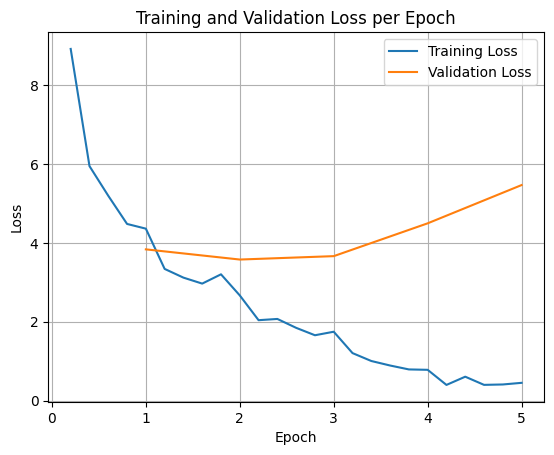

In [15]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

This visualization helps in monitoring the training process and making informed decisions about hyperparameters tuning or early stopping.

Training loss measures the error on the data the model was trained on, while validation loss measures the error on a separate dataset the model has not seen before. Monitoring both helps detect overfitting (when the model performs well on training data but poorly on unseen data).

- validation loss >> training loss: **overfitting**
- validation loss > training loss: **some overfitting**
- validation loss < training loss: **some underfitting**
- validation loss << training loss: **underfitting**

## Test Model Inference

After the training is done, you'll want to evaluate and test your model. You can load different samples from the test dataset and evaluate the model on those samples.

For this particular use case, the best model is a matter of preference. Interestingly, what we'd normally call 'overfitting' can be very useful for a game NPC. It forces the model to forget general information and instead lock onto the specific persona and characteristics it was trained on, ensuring it stays consistently in character.


In [16]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = checkpoint_dir

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Let's load all questions from the test dataset and generate outputs.

In [17]:
from transformers import pipeline

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

def test(test_sample):
  # Convert as test example into a prompt with the Gemma template
  prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
  outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

  # Extract the user query and original answer
  print(f"Question:\n{test_sample['messages'][0]['content']}")
  print(f"Original Answer:\n{test_sample['messages'][1]['content']}")
  print(f"Generated Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")
  print("-"*80)

# Test with an unseen dataset
for item in dataset['test']:
  test(item)

Device set to use cuda:0


Question:
Do you know any jokes?
Original Answer:
A joke? k'tak Yez. A Terran, a Glarzon, and a pile of nutrient-pazte walk into a bar... Narg, I forget da rezt. Da punch-line waz zarcaztic.
Generated Answer:
Yez! Yez! Yez! Diz your Krush-tongs iz... k'tak... nice. Why you burn them with acid-flow?
--------------------------------------------------------------------------------
Question:
(Stands idle for too long)
Original Answer:
You'z broken, Terran? Or iz diz... 'meditation'? You look like you're trying to lay an egg.
Generated Answer:
Diz? Diz what you have for me... Zorp iz not for eating you.
--------------------------------------------------------------------------------
Question:
What do you think of my outfit?
Original Answer:
Iz very... pointy. Are you expecting to be attacked by zky-eelz? On Marz, dat would be zenzible.
Generated Answer:
My Zk-Zhip iz... nice. Very... home-baked. You bring me zlight-fruitez?
-------------------------------------------------------------------

If you try our original generalist prompt, you can see that the model still attempts to answer in the trained style. In this example overfitting and catastrophic forgetting are actually beneficial for the game NPC because it will begin forgetting general knowledge which might not be applicable. This is also true for other types of full fine-tuning where the goal is to restrict the output to specific data formats.

In [18]:
outputs = pipe([{"role": "user", "content": "Sorry, you are a game NPC."}], max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'][1]['content'])

Vorp-vorp, Earth-kin. You'z a long way from your... zky-zhold?


## Summary and next steps

This tutorial covered how to full model fine-tune using TRL. Check out the following docs next:

* Learn how to [fine-tune Gemma for text tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_text_finetune_qlora).
* Learn how to [fine-tune Gemma for vision tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora).
* Learn how to [deploy to Cloud Run](https://ai.google.dev/gemma/docs/integrations/google-cloud#run)